# RelateAnything

In [1]:
%load_ext autoreload
%autoreload 2

from segment_anything import build_sam, SamPredictor, SamAutomaticMaskGenerator

/mnt/lustre/jkyang/anaconda3/envs/relate_anything/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
predictor = SamPredictor(build_sam(checkpoint="../checkpoints/sam_vit_h_4b8939.pth"))
mask_generator = SamAutomaticMaskGenerator(build_sam(checkpoint="../checkpoints/sam_vit_h_4b8939.pth"))

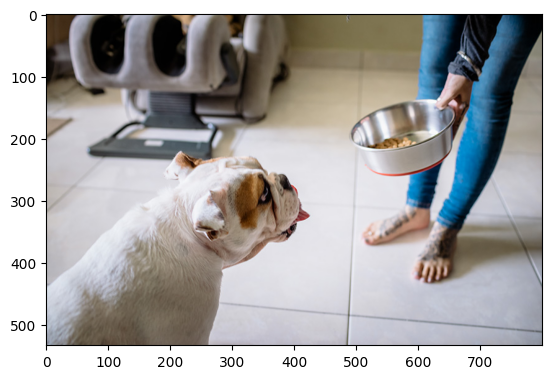

In [44]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

image_name = './images/dog.jpg'

image = cv2.imread(image_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

pilimage = Image.open(image_name)
width, height = pilimage.size
full_area = width * height

plt.imshow(image)
plt.show()

### Segment Everything

In this part, we have sam_feats as all masks features.

In [163]:
sam_masks = mask_generator.generate(image)

In [69]:
filtered_masks = [d for d in sam_masks if d['area'] > 0.03 * full_area]
print('number of masks left:', len(filtered_masks))

number of masks left: 10


In [89]:
def show_anns(anns, color='auto'):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        if color == 'auto':
            for i in range(3):
                img[:,:,i] = color_mask[i]
        else:
            for i in range(3):
                img[:,:,0] = 1
                img[:,:,1] = 0
                img[:,:,2] = 0
    return np.dstack((img, m*0.35))

In [47]:
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', 
               s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', 
               s=marker_size, edgecolor='white', linewidth=1.25)   

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

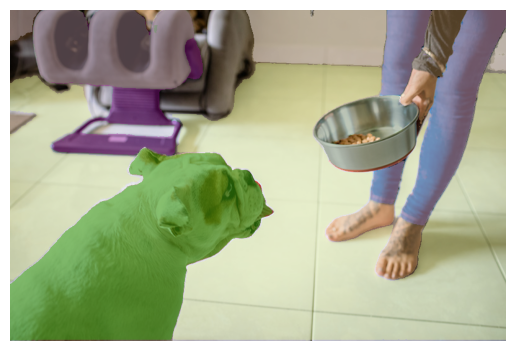

In [70]:
plt.imshow(image)
show_anns(filtered_masks)
plt.axis('off')
plt.show()

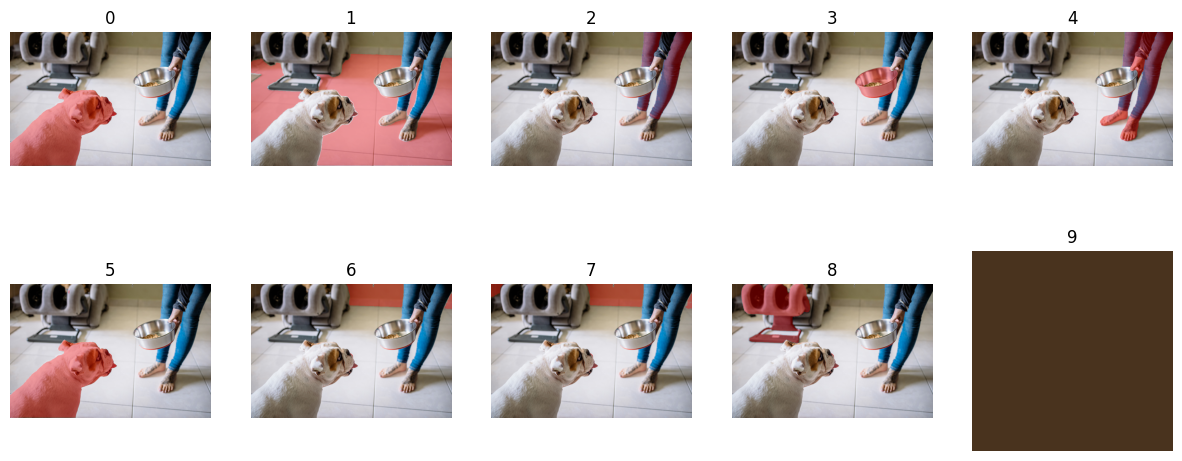

In [92]:
import math

# Calculate the number of rows needed
num_rows = math.ceil(len(filtered_masks) / 5)

# Create the subplots
fig, axs = plt.subplots(num_rows, 5, figsize=(15, 3*num_rows))

# Loop through the images and add them to the subplots
for i, mask in enumerate(filtered_masks):
    row = i // 5
    col = i % 5
    
    axs[row, col].imshow(image)
    axs[row, col].imshow(show_anns(filtered_masks[i:i+1], 'red'))
    axs[row, col].axis('off')
    axs[row, col].set_title(i)
    

# Display the subplots
plt.show()

### Segment with Prompt

In this section, we extract the mask feature as feats.

In [116]:
predictor.set_image(image)

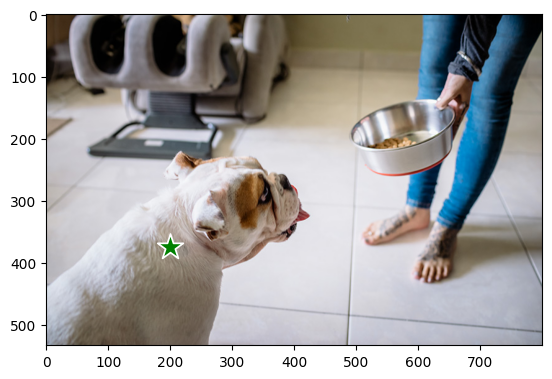

In [143]:
input_point = np.array([[200, 375]])
input_label = np.array([1])

# input_point = np.array([[600, 200]])
# input_label = np.array([1])

plt.imshow(image)
show_points(input_point, input_label, plt.gca())
# plt.axis('off')
plt.show()

In [157]:
masks, scores, logits, feats = predictor.predict(point_coords=input_point,
                                                 point_labels=input_label,
                                                 multimask_output=False,)

In [158]:
feats.shape

torch.Size([1, 1, 256])

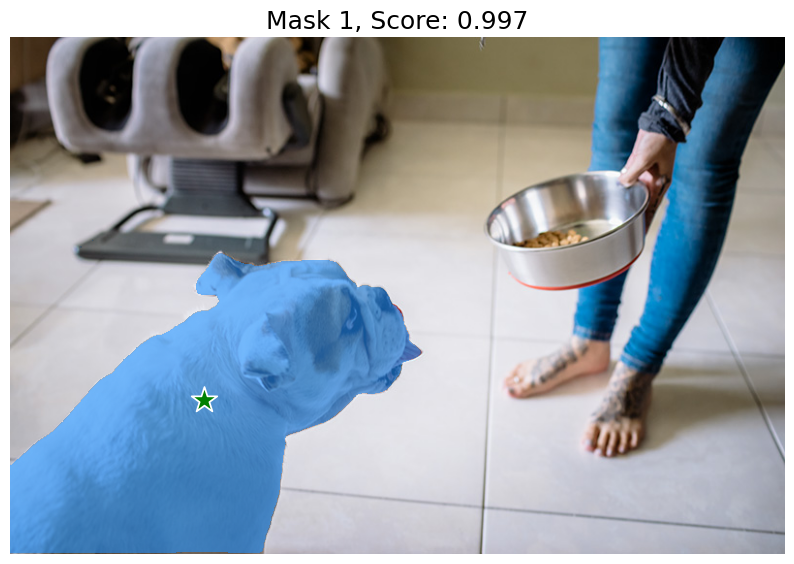

In [159]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show() 

### CLIP Feature (does not work)

In [17]:
import torch
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

/mnt/lustre/jkyang/anaconda3/envs/relate_anything/lib/python3.8/site-packages/clip/clip.py:24: UserWarning: PyTorch version 1.7.1 or higher is recommended
  warnings.warn("PyTorch version 1.7.1 or higher is recommended")


In [108]:
def xywh_to_xyxy(bbox):
    x, y, w, h = bbox
    return [x, y, x + w, y + h]

def union_bbox(bbox_A, bbox_B):
    x1_A, y1_A, x2_A, y2_A = bbox_A
    x1_B, y1_B, x2_B, y2_B = bbox_B
    x1_union = min(x1_A, x1_B)
    y1_union = min(y1_A, y1_B)
    x2_union = max(x2_A, x2_B)
    y2_union = max(y2_A, y2_B)
    return [x1_union, y1_union, x2_union, y2_union]

bbox_A = sam_masks[3]['bbox']
bbox_B = sam_masks[4]['bbox']

# Convert (x, y, w, h) format to (x1, y1, x2, y2) format
bbox_A_xyxy = xywh_to_xyxy(bbox_A)
bbox_B_xyxy = xywh_to_xyxy(bbox_B)

# Calculate the union bounding box
bbox_union = union_bbox(bbox_A_xyxy, bbox_B_xyxy)

# Crop and preprocess the images using the bounding boxes
cropped_image_A = crop_image(pilimage, bbox_A_xyxy)
cropped_image_B = crop_image(pilimage, bbox_B_xyxy)
cropped_image_union = crop_image(pilimage, bbox_union)

preprocessed_image_A = preprocess(cropped_image_A).unsqueeze(0).to(device)
preprocessed_image_B = preprocess(cropped_image_B).unsqueeze(0).to(device)
preprocessed_image_union = preprocess(cropped_image_union).unsqueeze(0).to(device)

# Extract the CLIP features for the bounding boxes and their union
with torch.no_grad():
    features_A = model.encode_image(preprocessed_image_A)
    features_B = model.encode_image(preprocessed_image_B)
    features_union = model.encode_image(preprocessed_image_union)
    relation_feat = features_union - 0.5 * (features_A + features_B)

In [170]:
from utils import words

In [103]:
sentences = []
for word in words:
    sentence = f"The image shows something is {word} something."
    sentences.append(sentence)

In [114]:
# matching the most suitable word
tokenized_words = clip.tokenize(sentences).to(device)
with torch.no_grad():
    word_features = model.encode_text(tokenized_words)

# similarity_scores = torch.matmul(relation_feat, word_features.T)
similarity_scores = torch.matmul(features_A, word_features.T)
similarity_scores = torch.matmul(features_B, word_features.T)
similarity_scores = torch.matmul(features_union, word_features.T)

best_word_indices = torch.argmax(similarity_scores, dim=1).tolist()
best_matching_words = [words[i] for i in best_word_indices]
print(best_matching_words)

['cooking']
